## Zeitliche Auflösung des Chrom 60 Drahtes im CCA Modus

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from math import floor, ceil, log10
import pandas as pd
import codecs

# https://stackoverflow.com/questions/3410976/how-to-round-a-number-to-significant-figures-in-python
# https://stackoverflow.com/questions/23207055/rounding-errors-to-1-significant-figure-and-round-values-according-to-number-of
def round_to_n(data, n=1):
    if n != 1:
        return [round(x, -int(floor(log10(np.abs(x)))) + (n - 1)) for x in data]
    else:
        return [round(x, -int(floor(log10(np.abs(x))))) for x in data]

# returns data and error rounded to significance of error
def round_to_reference(data, ref, n):
    ref = round_to_n(ref, n)
    return ([round(x, -int(floor(log10(y))) + (n - 1)) for (x,y) in zip(data, ref)], ref)

rtn = round_to_n
rtr = round_to_reference

def moving_average(x, window_len):
    return np.convolve(x, np.ones(window_len), 'valid') / window_len

# For intersection
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (array[idx], idx)

# Fit
def Kings_Law (x, const, m, B):
    y = const + m * (x-B)**4
    return y

# Returns flow velocity and uncertainty
def U_Düse_in_v(U):
    return (U*4.749, U*0.031)

label_size = 20
plt.rcParams.update({'font.size': label_size, 'legend.title_fontsize': 18, 'legend.fontsize': 18, "axes.labelsize": label_size, "xtick.labelsize": label_size, 
"ytick.labelsize": label_size, "axes.labelpad": 4, "lines.markersize": 10, "lines.linewidth": 2})

In [3]:
with open("R/CCA_resolution/3.3.2_Aufl_CCA_1_x.txt", "r") as file:
    data_backup = np.array(file.read().splitlines(), float)

### Gesamte Zeitserie

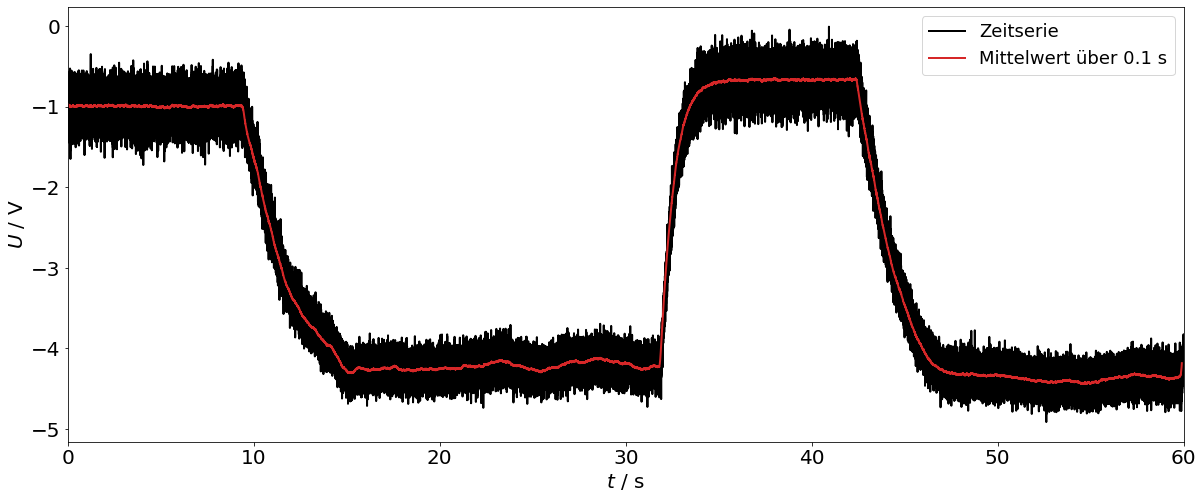

In [32]:
data = data_backup
# Convert time to num data points
def c(time, o=0, s_freq = 10000):
    # o = offset
    return int((time+o)*s_freq)
# Inverse function
def ci(num, s_freq = 10000):
    return (num/s_freq)

s_freq= 10000 # Sampling frequency
# Beginning and end of time series plot
tb = c(0)
te = c(60)
time = np.arange(0, len(data)/s_freq, 1/s_freq)
time = time[tb:te]

fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(time, data[tb:te], c="black", label="Zeitserie")

t_avg = 1000
data_avg = moving_average(data[tb:te], t_avg)
ax.plot(time[0:len(data_avg)], data_avg, c="C3", label=f"Mittelwert über {t_avg/s_freq} s")
ax.set_xlabel("$t$ / s")
ax.set_ylabel("$U$ / V")
ax.set_xlim(0,60)
ax.legend()
plt.savefig("Abb/Aufl_3_2__Zeitserie_gesamt.png")

### Abfallende Flanke

AttributeError: 'numpy.float64' object has no attribute 'update'

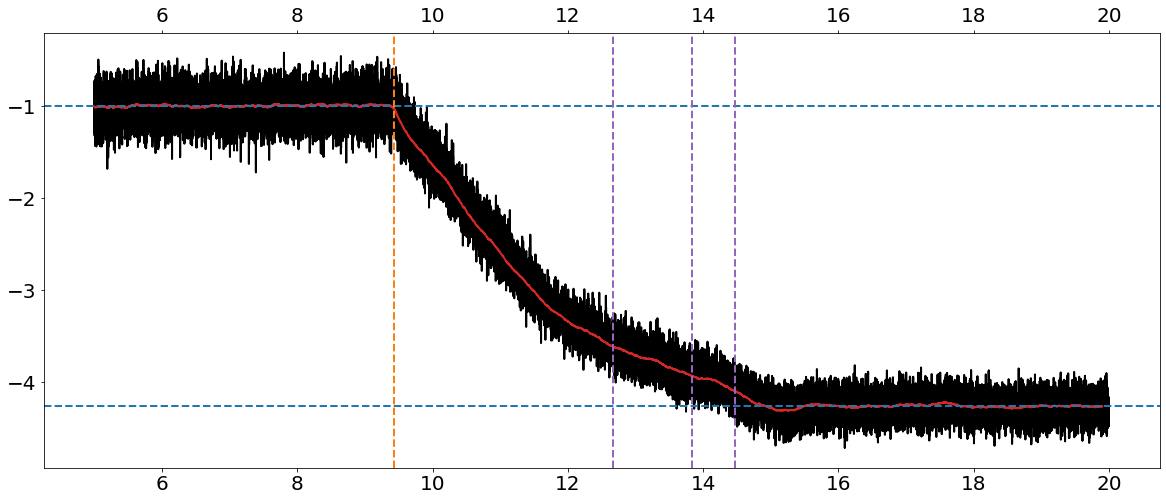

In [84]:
# Begrenze Zeitserie, das hilft später beim Schnittpunkt finden und vereinfacht Index->Zeit Konvertierung
data = data_backup
s_freq= 10000 # Sampling frequency
# Beginning and end of time series plot

tb = c(5)
te = c(20)
time = np.arange(0, len(data)/s_freq, 1/s_freq)
time = time[tb:te]
data = data[tb:te]

fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(time, data, c="black", label="Zeitserie")

t_avg = 1000
data_avg = moving_average(data, t_avg)
ax.plot(time[0:len(data_avg)], data_avg, c="C3", label=f"Mittelwert über {t_avg/s_freq} s")

# Hier muss man immer c(x) bei x, 5 abziehen, weil arrays ab 5 Sekunden anfangen und Index
# der Array sonst nicht richtig berechent wird
# Start
U_b = np.round(np.mean(data[0:c(9)-tb]),3)
ax.axhline(U_b, ls="--", label= "$U_{start}$"+f" = {U_b}")

# End
U_e = np.round(np.mean(data[c(16)-tb:c(20)-tb]),3)
ax.axhline(U_e, ls="--", label= "$U_{end}$"+f" = {U_e}")

# Fall until x%
U_delta = np.abs(U_e-U_b)
U_f_80 = U_b-U_delta*0.8
(t_f_80, t_f_80_idx) = find_nearest(data_avg, U_f_80)
ax.axvline(ci(t_f_80_idx+tb), ls="--", label= "$U_{80}$"+f" = {U_f_80}", c="C4")

U_f_90 = U_b-U_delta*0.9
(t_f_90, t_f_90_idx) = find_nearest(data_avg, U_f_90)
ax.axvline(ci(t_f_90_idx+tb), ls="--", label= "$U_{90}$"+f" = {U_f_90}", c="C4")

U_f_95 = U_b-U_delta*0.95
(t_f_95, t_f_95_idx) = find_nearest(data_avg, U_f_95)
ax.axvline(ci(t_f_95_idx+tb), ls="--", label= "$U_{95}$"+f" = {U_f_95}", c="C4")

# First manual method
# ts = c(9.4) # Start of drop off/edge
# (t_f_0, t_f_0_idx) = find_nearest(data_avg[ts-tb:], U_b)
# ax.axvline(ci(t_f_0_idx+ts), ls="--", label= "$U_{drop}$"+f" = {U_f_0}", c="C1")

# Automatic --> First time difference to start value is greater than 1%
U_f_0 = U_b-U_delta*0.01
(t_f_0, t_f_0_idx) = find_nearest(data_avg, U_f_0)
ax.axvline(ci(t_f_0_idx+tb), ls="--", label= "$U_{drop}$"+f" = {U_f_0}", c="C1")

extra_ticks = [ci(t_f_80_idx+tb), ci(t_f_90_idx+tb), ci(t_f_95_idx+tb), ci(t_f_0_idx+tb)]
# extra_ticks.extend(ax.get_xticks())
# ax.set_xticks(extra_ticks)
ax.tick_params(axis="x", top=True, labeltop=True)
plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="left", va="center",rotation_mode="anchor")

ax.set_xlabel("$t$ / s")
ax.set_ylabel("$U$ / V")
ax.set_xlim(5,20)
ax.legend()
plt.savefig("Abb/Aufl_3_2__Zeitserie_gesamt.png")

In [73]:
a=list(ax.get_xticks())

In [77]:
extra_ticks.extend(a)

In [78]:
extra_ticks

[12.6655,
 13.8411,
 14.4773,
 9.4296,
 4.0,
 6.0,
 8.0,
 10.0,
 12.0,
 14.0,
 16.0,
 18.0,
 20.0,
 22.0]

In [37]:
t_f_0_idx+ts

100019

In [38]:
ci(t_f_0_idx+ts)

10.0019